<a href="https://colab.research.google.com/github/PinkOrangeSapphire/223351/blob/main/229351_LAB10_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 8

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 24 เดือนสุดท้ายและ Training set เป็นข้อมูลก่อนหน้าทั้งหมด
3. ลองสร้างโมเดล Holt-Winters แบบต่างๆ (damped, non-damped, additive, multiplicative etc.) แล้วระบุโมเดลที่ดีที่ให้ค่า RMSE บน test set น้อยที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-16 18:03:25--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 188.114.96.0, 188.114.97.0, 2a06:98c1:3121::, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|188.114.96.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.008s  

2025-09-16 18:03:25 (15.8 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [2]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime

In [3]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.tail()

/tmp/ipython-input-2705365328.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
2019-07-27,26.2
2019-07-28,34.2
2019-07-29,34.4
2019-07-30,33.5
2019-07-31,30.7


ข้อมูลที่ได้เป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วย method `resample`

In [4]:
data_monthly = data['MaxTemp'].resample("M").mean()

data_monthly.head()

/tmp/ipython-input-3219926365.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_monthly = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [5]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

Training set size: 235
Test set size: 24
Best model: damped_multiplicative with RMSE: 1.11


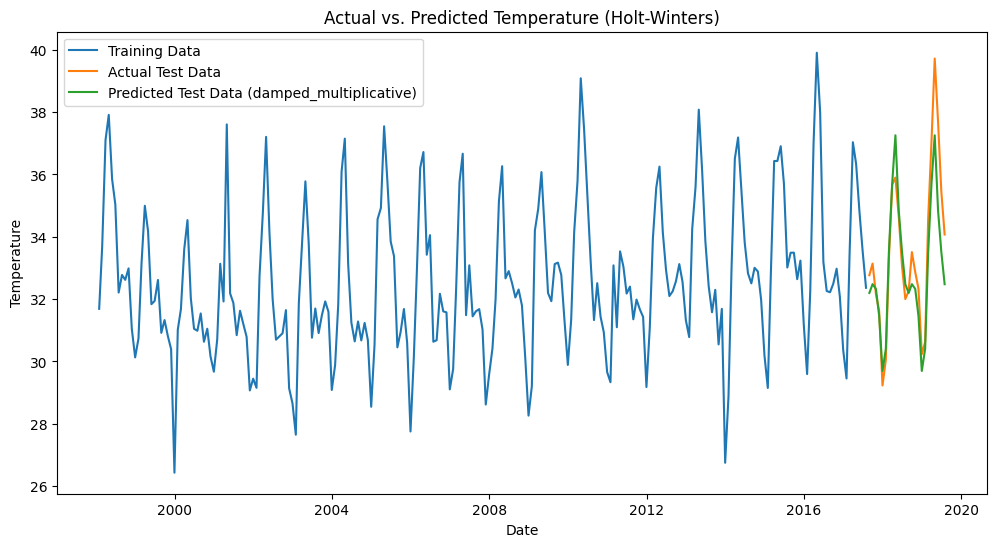

In [11]:
# แบ่งข้อมูลเป็น Training set และ Test set (24 เดือนสุดท้าย)
train_size = len(data_monthly) - 24
train_data, test_data = data_monthly[:train_size], data_monthly[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# สร้างโมเดล Holt-Winters แบบต่างๆ
models = {
    "additive": ExponentialSmoothing(train_data, seasonal_periods=12, trend='add', seasonal='add').fit(),
    "multiplicative": ExponentialSmoothing(train_data, seasonal_periods=12, trend='mul', seasonal='mul').fit(),
    "damped_additive": ExponentialSmoothing(train_data, seasonal_periods=12, trend='add', seasonal='add', damped_trend=True).fit(),
    "damped_multiplicative": ExponentialSmoothing(train_data, seasonal_periods=12, trend='mul', seasonal='mul', damped_trend=True).fit(),
}

# คำนวณ RMSE บน Test set then หาโมเดลที่ดีที่สุด
rmse_values = {}
for name, model in models.items():
    predictions = model.predict(start=test_data.index[0], end=test_data.index[-1])
    rmse_values[name] = rmse(test_data, predictions)

best_model_name = min(rmse_values, key=rmse_values.get)
best_model = models[best_model_name]

print(f"Best model: {best_model_name} with RMSE: {rmse_values[best_model_name]:.2f}")

# use โมเดลที่ดีที่สุด
test_predictions = best_model.predict(start=test_data.index[0], end=test_data.index[-1])

# Show Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_predictions.index, test_predictions, label=f'Predicted Test Data ({best_model_name})')
plt.title('Actual vs. Predicted Temperature (Holt-Winters)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()